Per evitare di dover rieseguire tutto il Colab ogni volta, la SVM addestrata è salvata su Drive. Per far funzionare il codice non serve quindi eseguire le celle "Oversampling", "SVM training" e "Salvataggio SVM".

# Importazione e modifica dati

In [ ]:
from google.colab import drive 
import pandas as pd
import re
import numpy as np
from math import exp

from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

import joblib

import matplotlib.pyplot as plt
import matplotlib.colors as clr
plt.rcParams['figure.figsize'] = [10, 7] # dimensione grafici

# Colore degli elementi nei grafici
colore_scelto = (0,0.6,0.9,1) # azzurro
#colore_scelto = (0.98, 0.19, 0.13, 1) # rosso
#colore_scelto = (0.90, 0.56, 0.16, 1) # beige

# Dimensione dei font
font_label = 15
font_title = 20

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/DS Lab - PROGETTO/Ottobre/dataset_normalizzato.csv')

In [ ]:
df.head()

,ad_form_id,clicks,impressions,os_android,os_bsd,os_ios,os_linux,os_osx,os_other,os_windows,...,categories2_welfare,categories2_windsurfing,categories2_womenshealth,categories2_work,categories2_wrestling,categories2_zoo,feelings1_amusement,feelings1_emotions,feelings1_pain,feelings1_others
0,8408205703932483258,0,1,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
1,6157419832685345406,0,3,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2,6336227050936118437,0,3,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,56.25,43.75,0.0,0.0
3,6272249560265519045,0,5,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
4,2248420359615433360,0,5,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0


Aggiungiamo colonna click_status:

In [ ]:
def clickstatus(riga):
  if riga['clicks']>0:
    return 'yes'
  else:
    return 'no'

df['click_status'] = df.apply(clickstatus, axis=1)
df.drop(columns='clicks', inplace=True)

In [ ]:
# totale dei click
len(df[df['click_status']=='yes'])

189

In [ ]:
# totale dei non click
len(df[df['click_status']=='no'])

62190

Eliminazione colonna Id e Impression:

In [ ]:
df.drop(columns='ad_form_id', inplace=True)

In [ ]:
df.drop(columns='impressions', inplace=True)

Tipi delle variabili:

In [ ]:
df.dtypes

os_android               int64
os_bsd                   int64
os_ios                   int64
os_linux                 int64
os_osx                   int64
                        ...   
feelings1_amusement    float64
feelings1_emotions     float64
feelings1_pain         float64
feelings1_others       float64
click_status            object
Length: 425, dtype: object

In [ ]:
df = df.astype({
    'os_android':'bool',
    'os_bsd':'bool',
    'os_ios':'bool',
    'os_linux':'bool',
    'os_osx':'bool',
    'os_other':'bool',
    'os_windows':'bool',
    'device_type':'object',
    'browser_android':'bool',
    'browser_chrome':'bool',
    'browser_chromium':'bool',
    'browser_edge':'bool',
    'browser_firefox':'bool',
    'browser_ie':'bool',
    'browser_opera':'bool',
    'browser_other':'bool',
    'browser_safari':'bool',
    'browser_unknown':'bool'
}) 

# Caricamento SVM

In [ ]:
try:
  pipeline = joblib.load('/content/gdrive/My Drive/DS Lab - PROGETTO/Ottobre/SVM_cat2_no_feelings.sav')
except:
  print('Il file SVM_cat2.sav non è stato trovato.')

# Dataset per il training

Tengo solo le categories2, elimino le 1. Successivamente tolgo i feelings

In [ ]:
colonne = df.columns

# Colonne categories1
cat1 = re.compile('categories1_+.*', re.IGNORECASE)
cats1 = []
for label in colonne:
  occ = cat1.findall(label)
  if occ:
    cats1.append(occ[0])

df.drop(columns=cats1, inplace=True)

In [ ]:
df

,os_android,os_bsd,os_ios,os_linux,os_osx,os_other,os_windows,device_type,browser_android,browser_chrome,...,categories2_windsurfing,categories2_womenshealth,categories2_work,categories2_wrestling,categories2_zoo,feelings1_amusement,feelings1_emotions,feelings1_pain,feelings1_others,click_status
0,False,False,False,False,False,False,True,2,False,False,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,no
1,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,no
2,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,56.25,43.75,0.0,0.0,no
3,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,no
4,False,False,False,False,False,False,True,2,False,False,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62374,False,False,False,False,True,False,False,2,False,True,...,0.0,0.0,0.0,0.0,0.0,56.10,43.90,0.0,0.0,no
62375,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,no
62376,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,no
62377,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,56.17,43.96,0.0,0.0,no


In [ ]:
colonne = df.columns

# Colonne categories1
fel = re.compile('feelings1_+.*', re.IGNORECASE)
feel = []
for label in colonne:
  occ = fel.findall(label)
  if occ:
    feel.append(occ[0])

df.drop(columns=feel, inplace=True)

In [ ]:
df

,os_android,os_bsd,os_ios,os_linux,os_osx,os_other,os_windows,device_type,browser_android,browser_chrome,...,categories2_weather,categories2_weightlifting,categories2_weightloss,categories2_welfare,categories2_windsurfing,categories2_womenshealth,categories2_work,categories2_wrestling,categories2_zoo,click_status
0,False,False,False,False,False,False,True,2,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
1,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
2,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
3,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
4,False,False,False,False,False,False,True,2,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62374,False,False,False,False,True,False,False,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
62375,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
62376,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no
62377,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no


Il dataset ha ora 395 colonne.

# Split train test

In [ ]:
feature_names = df.columns.drop('click_status')

(train_x, test_x,
 train_y, test_y) = train_test_split(df[feature_names], 
                                     df['click_status'],
                                     test_size=0.3, 
                                     random_state=42)

# Oversampling

In [ ]:
# Randomly over sample the minority class
ros = RandomOverSampler(random_state=42)
train_x_ros, train_y_ros= ros.fit_resample(train_x, train_y)
# Check the number of records after over sampling
print(sorted(Counter(train_y_ros).items()))

[('no', 43529), ('yes', 43529)]


In [ ]:
# controllo tipo colonne
df.dtypes

os_android                     bool
os_bsd                         bool
os_ios                         bool
os_linux                       bool
os_osx                         bool
                             ...   
categories2_womenshealth    float64
categories2_work            float64
categories2_wrestling       float64
categories2_zoo             float64
click_status                 object
Length: 395, dtype: object

In [ ]:
# Controllo train set oversamplato
train_x_ros

,os_android,os_bsd,os_ios,os_linux,os_osx,os_other,os_windows,device_type,browser_android,browser_chrome,...,categories2_waterskiwakeboard,categories2_weather,categories2_weightlifting,categories2_weightloss,categories2_welfare,categories2_windsurfing,categories2_womenshealth,categories2_work,categories2_wrestling,categories2_zoo
0,False,False,False,False,True,False,False,2,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,False,False,False,False,False,True,2,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87053,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87054,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87055,False,False,False,False,False,False,True,2,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87056,False,False,False,False,False,False,True,2,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# SVM training

In [ ]:
# Seleziono variabili categoriche e numeriche
cat_ix = train_x_ros.select_dtypes(include=['object', 'bool']).columns
num_ix = train_x_ros.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
# Encoding e normalizzazione (tra 0 e 1)
ct = ColumnTransformer([('c', OneHotEncoder(handle_unknown = 'ignore'), cat_ix),
                        ('n', MinMaxScaler(), num_ix)])

In [ ]:
# SVM
model = svm.LinearSVC()

In [ ]:
# Definisco pipeline
pipeline = Pipeline(steps=[('t', ct), ('m', model)])

In [ ]:
# Addestramento
pipeline.fit(train_x_ros, train_y_ros)

Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('c',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['os_android', 'os_bsd', 'os_ios', 'os_linux', 'os_osx', 'os_other',
       'os_windows', 'device_type', 'browser_android', 'browser_chrome',
       'browser_chromium', 'browser_edge', 'browser_firefox', 'browser_ie',
       'browser_opera', 'browser_other', 'browser_safari', 'browser...
       'time1_weekend_afternoon', 'time1_weekend_evening',
       'time1_weekend_night', 'L00_50', 'L51_100',
       ...
       'categories2_waterskiwakeboard', 'categories2_weather',
       'categories2_weightlifting', 'categories2_weightloss',
       'categories2_welfare', 'categories2_windsurfing',
       'categories2_womenshealth', 'categories2_work', 'categories2_wrestling',
       'categories2_zoo'],
      dtype='object', length=376))])),
                ('m', LinearSVC())])

In [ ]:
# Performance sul train test
y_pred_train = pipeline.predict(train_x_ros)
print(classification_report(train_y_ros, y_pred_train)) # precision, recall e altre misure di performance

              precision    recall  f1-score   support

          no       0.71      0.62      0.66     43529
         yes       0.66      0.75      0.70     43529

    accuracy                           0.68     87058
   macro avg       0.69      0.68      0.68     87058
weighted avg       0.69      0.68      0.68     87058



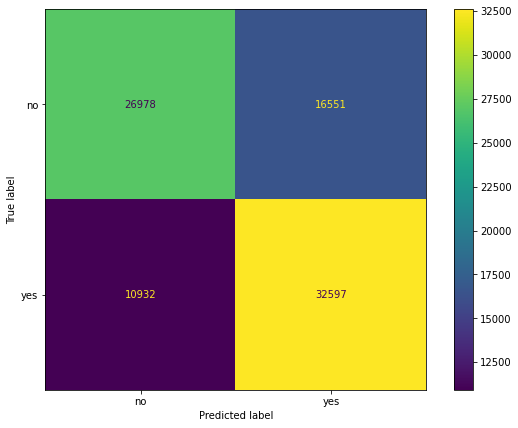

In [ ]:
# Matrice di confusione
ConfusionMatrixDisplay.from_estimator(pipeline, train_x_ros, train_y_ros);

In [ ]:
# Percentuali:
a = 26978
b = 16551
c = 10932
d = 32597
no = a + b
yes = c + d
CM11 = round(a / no, 2)
CM12 = round(b / no, 2)
CM21 = round(c / yes, 2)
CM22 = round(d / yes, 2)
print(f'% no classificati come no: {CM11}\n% no classicati come sì: {CM12}\n% sì classificati come no: {CM21}\n% sì classificati come sì: {CM22}')

% no classificati come no: 0.62
% no classicati come sì: 0.38
% sì classificati come no: 0.25
% sì classificati come sì: 0.75


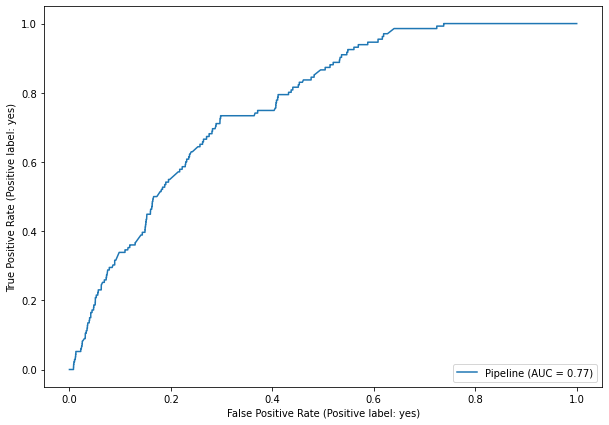

In [ ]:
# Curva ROC
RocCurveDisplay.from_estimator(pipeline, train_x_ros, train_y_ros);

# Salvataggio della SVM

In [ ]:
# Eseguire solo se si riaddestra la SVM
#joblib.dump(pipeline, '/content/gdrive/My Drive/DS Lab - PROGETTO/Ottobre/SVM_cat2_no_feelings.sav')

['/content/gdrive/My Drive/DS Lab - PROGETTO/Ottobre/SVM_cat2_no_feelings.sav']

In [ ]:
# Versione di sklearn
import sklearn
sklearn.__version__

'1.0.2'

SVM salvata con versione 1.0.2 di `sklearn`.

# Test

In [ ]:
# Predizione su test set
y_pred = pipeline.predict(test_x)
print(classification_report(test_y, y_pred)) # precision, recall e altre misure di performance

              precision    recall  f1-score   support

          no       1.00      0.62      0.76     18661
         yes       0.00      0.64      0.01        53

    accuracy                           0.62     18714
   macro avg       0.50      0.63      0.39     18714
weighted avg       1.00      0.62      0.76     18714



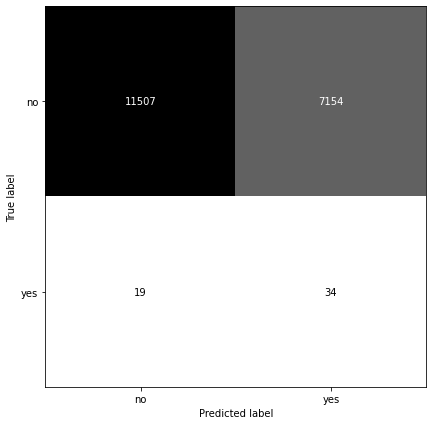

In [ ]:
# Matrice di confusione
ConfusionMatrixDisplay.from_estimator(pipeline, test_x, test_y, colorbar=False, cmap='gist_yarg');

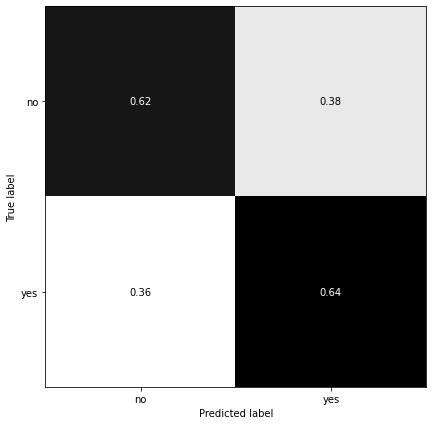

In [ ]:
# Matrice di confusione con percentuali
ConfusionMatrixDisplay.from_estimator(pipeline, test_x, test_y, colorbar=False, cmap='binary', normalize='true');

In [ ]:
# Percentuali:
a = 11507
b = 7154
c = 19
d = 34
no = a + b
yes = c + d
CM11 = round(a / no, 2)
CM12 = round(b / no, 2)
CM21 = round(c / yes, 2)
CM22 = round(d / yes, 2)
print(f'% no classificati come no: {CM11}\n% no classicati come sì: {CM12}\n% sì classificati come no: {CM21}\n% sì classificati come sì: {CM22}')

% no classificati come no: 0.62
% no classicati come sì: 0.38
% sì classificati come no: 0.36
% sì classificati come sì: 0.64


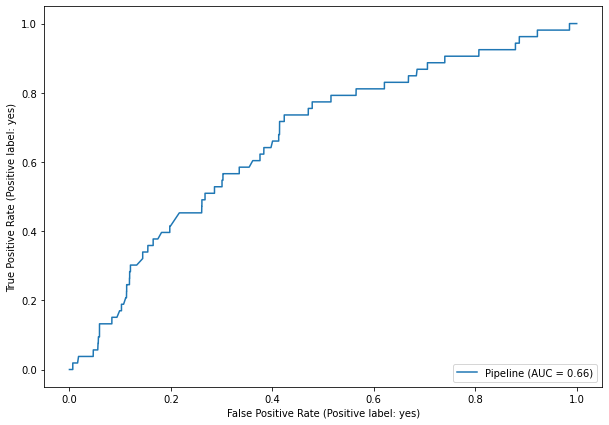

In [ ]:
# Curva ROC
RocCurveDisplay.from_estimator(pipeline, test_x, test_y);

# Costruzione del dataframe per la valutazione

Innanzitutto portiamo la confidenza tra 0 e 1.

Da guida di `sklearn` su decision function di `linearSVC`:

*Predict confidence scores for samples.*

*The confidence score for a sample is proportional to the signed distance of that sample to the hyperplane.*

*Parameters*
  * *X{array-like, sparse matrix} of shape (`n_samples`, `n_features`)*
    * *The data matrix for which we want to get the confidence scores.*

*Returns*
  * *scores: ndarray of shape (`n_samples`,) or (`n_samples`, `n_classes`)*
    * *Confidence scores per (`n_samples`, `n_classes`) combination. In the binary case, confidence score for `self.classes_[1]` where >0 means this class would be predicted.*

In [ ]:
# Confidenza dei sì
probs = list(pipeline.decision_function(test_x))

In [ ]:
probs[:10]

[-1.9712074992924875,
 0.6149505690557887,
 -2.353462570121701,
 -0.1850699174540028,
 -0.27999412551465797,
 -1.2080021121819096,
 -0.14538208385794482,
 -0.6064625612058069,
 -3.1868333941682505,
 -1.2499132059870792]

In [ ]:
# Le entrate negative sono associate al no, le positive al sì, come mostrato qui sotto
y_pred[:10]

array(['no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no'],
      dtype=object)

In [ ]:
# Costruisco ora dataframe con id, la classe vera, la classe predetta e la probabilità associata al sì
yes_df = pd.DataFrame()

In [ ]:
yes_df['id'] = range(len(probs))
yes_df['Class'] = list(test_y)
yes_df['Predicted'] = list(y_pred)
yes_df['Confidence of yes'] = probs

In [ ]:
yes_df

,id,Class,Predicted,Confidence of yes
0,0,no,no,-1.971207
1,1,no,yes,0.614951
2,2,no,no,-2.353463
3,3,no,no,-0.185070
4,4,no,no,-0.279994
...,...,...,...,...
18709,18709,no,no,-0.214991
18710,18710,no,no,-1.752254
18711,18711,no,no,-0.020967
18712,18712,no,yes,0.222207


Si può mappare la confidenza tra 0 e 1 usando:

$\frac{1}{1+e^{-c}},$

con c livello di confidenza

**ATTENZIONE**: i valori non seguono nessuna distribuzione di probabilità.

In [ ]:
def ctp(riga):
  return 1 / (1 + exp(-riga['Confidence of yes']))
yes_df['Confidence of yes'] = yes_df.apply(ctp, axis=1)

In [ ]:
yes_df[yes_df['Class'] == 'yes'].sort_values('Confidence of yes', ascending=False)

,id,Class,Predicted,Confidence of yes
17123,17123,yes,yes,0.726310
14815,14815,yes,yes,0.656587
11574,11574,yes,yes,0.618798
1388,1388,yes,yes,0.611538
13508,13508,yes,yes,0.610220
13515,13515,yes,yes,0.607616
8038,8038,yes,yes,0.607616
7457,7457,yes,yes,0.592681
13108,13108,yes,yes,0.588881
4761,4761,yes,yes,0.586825


In [ ]:
yes_df.groupby('Class').size()

Class
no     18661
yes       53
dtype: int64

In [ ]:
Nno = 18661
Nyes = 53

# Valutazione performance con curva ROC

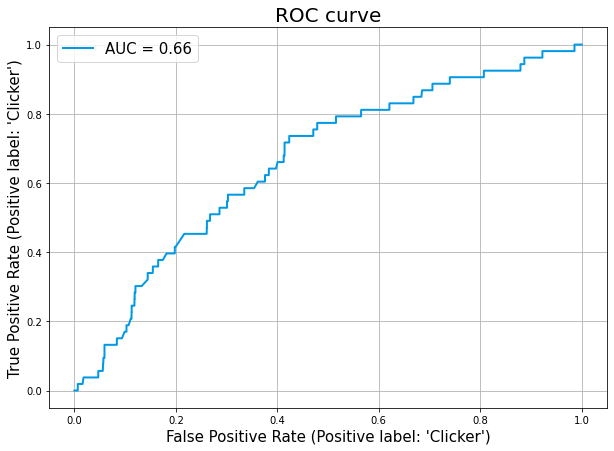

In [ ]:
RocCurveDisplay.from_estimator(pipeline, test_x, test_y, color=colore_scelto, linewidth=2);
plt.grid();
plt.title('ROC curve', fontsize=font_title);
plt.xlabel("False Positive Rate (Positive label: 'Clicker')", fontsize=font_label);
plt.ylabel("True Positive Rate (Positive label: 'Clicker')", fontsize=font_label);
plt.legend(["AUC = 0.66"], fontsize=font_label);

## Determinazione della soglia

In [ ]:
yes_df

,id,Class,Predicted,Confidence of yes
0,0,no,no,0.122259
1,1,no,yes,0.649069
2,2,no,no,0.086791
3,3,no,no,0.453864
4,4,no,no,0.430455
...,...,...,...,...
18709,18709,no,no,0.446458
18710,18710,no,no,0.147763
18711,18711,no,no,0.494759
18712,18712,no,yes,0.555324


In [ ]:
soglie = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # soglie a cui guardiamo true positive rate e false positive rate
tprs = [] # vettore con i tp rate
fprs = [] # vettore con i fp rate

for soglia in soglie:
  predizioni = []
  for confidenza in yes_df['Confidence of yes'].tolist():
    if confidenza > soglia:
      predizioni.append('yes')
    else:
      predizioni.append('no')

  # Aggiorniamo la colonna prediction soglia
  yes_df['Prediction soglia'] = predizioni

  # Calcoliamo i tp e gli fp
  tp = len(yes_df[(yes_df['Class'] == 'yes') & (yes_df['Prediction soglia'] == 'yes')])
  fp = len(yes_df[(yes_df['Class'] == 'no') & (yes_df['Prediction soglia'] == 'yes')])

  # Calcoliamo i rate
  tpr = tp / len(yes_df[yes_df['Class'] == 'yes'])
  fpr = fp / len(yes_df[yes_df['Class'] == 'no'])

  # Aggiorniamo i vettori
  tprs.append(tpr)
  fprs.append(fpr)

In [ ]:
# Dataframe per visualizzare bene
df_soglie_rate = pd.DataFrame()
df_soglie_rate['Soglia'] = soglie
df_soglie_rate['True positive rate'] = tprs
df_soglie_rate['False positive rate'] = fprs

df_soglie_rate

,Soglia,True positive rate,False positive rate
0,0.1,0.962264,0.905578
1,0.2,0.924528,0.873319
2,0.3,0.924528,0.815980
3,0.4,0.867925,0.685387
4,0.5,0.641509,0.383366
5,0.6,0.132075,0.070736
6,0.7,0.018868,0.009485
7,0.8,0.000000,0.001554
8,0.9,0.000000,0.000482
9,1.0,0.000000,0.000000


**I RISULTATI A SOGLIA 0.5 COINCIDONO CON QUELLI DELLA MATRICE DI CONFUSIONE, MEGA YEEE!!!!!**

Visti i risultati, analizziamo meglio tra 0.3 e 0.5.

In [ ]:
soglie = np.arange(0.3, 0.51, 0.01)
tprs = [] # vettore con i tp rate
fprs = [] # vettore con i fp rate

for soglia in soglie:
  predizioni = []
  for confidenza in yes_df['Confidence of yes'].tolist():
    if confidenza > soglia:
      predizioni.append('yes')
    else:
      predizioni.append('no')

  # Aggiorniamo la colonna predict soglia
  yes_df['Prediction soglia'] = predizioni

  # Calcoliamo i tp e gli fp
  tp = len(yes_df[(yes_df['Class'] == 'yes') & (yes_df['Prediction soglia'] == 'yes')])
  fp = len(yes_df[(yes_df['Class'] == 'no') & (yes_df['Prediction soglia'] == 'yes')])

  # Calcoliamo i rate
  tpr = tp / len(yes_df[yes_df['Class'] == 'yes'])
  fpr = fp / len(yes_df[yes_df['Class'] == 'no'])

  # Aggiorniamo i vettori
  tprs.append(tpr)
  fprs.append(fpr)

In [ ]:
# Dataframe per visualizzare bene
df_soglie_rate = pd.DataFrame()
df_soglie_rate['Soglia'] = soglie
df_soglie_rate['True positive rate'] = tprs
df_soglie_rate['False positive rate'] = fprs

df_soglie_rate

,Soglia,True positive rate,False positive rate
0,0.30,0.924528,0.815980
1,0.31,0.905660,0.805262
2,0.32,0.905660,0.789347
3,0.33,0.905660,0.776754
4,0.34,0.905660,0.765286
5,0.35,0.905660,0.755372
6,0.36,0.905660,0.741600
7,0.37,0.886792,0.725149
8,0.38,0.886792,0.712824
9,0.39,0.867925,0.701570


Visti i risultati, analizziamo meglio tra 0.45 e 0.48.

In [ ]:
soglie = np.arange(0.45, 0.481, 0.001)
tprs = [] # vettore con i tp rate
fprs = [] # vettore con i fp rate

for soglia in soglie:
  predizioni = []
  for confidenza in yes_df['Confidence of yes'].tolist():
    if confidenza > soglia:
      predizioni.append('yes')
    else:
      predizioni.append('no')

  # Aggiorniamo la colonna predict soglia
  yes_df['Prediction soglia'] = predizioni

  # Calcoliamo i tp e gli fp
  tp = len(yes_df[(yes_df['Class'] == 'yes') & (yes_df['Prediction soglia'] == 'yes')])
  fp = len(yes_df[(yes_df['Class'] == 'no') & (yes_df['Prediction soglia'] == 'yes')])

  # Calcoliamo i rate
  tpr = tp / len(yes_df[yes_df['Class'] == 'yes'])
  fpr = fp / len(yes_df[yes_df['Class'] == 'no'])

  # Aggiorniamo i vettori
  tprs.append(tpr)
  fprs.append(fpr)

In [ ]:
# Dataframe per visualizzare bene
df_soglie_rate = pd.DataFrame()
df_soglie_rate['Soglia'] = soglie
df_soglie_rate['True positive rate'] = tprs
df_soglie_rate['False positive rate'] = fprs

df_soglie_rate

,Soglia,True positive rate,False positive rate
0,0.450,0.792453,0.529607
1,0.451,0.792453,0.526231
2,0.452,0.792453,0.522748
3,0.453,0.792453,0.520765
4,0.454,0.792453,0.517604
5,0.455,0.773585,0.515514
6,0.456,0.773585,0.512620
7,0.457,0.773585,0.510208
8,0.458,0.773585,0.507475
9,0.459,0.773585,0.504528


La scelta più sensata sembra essere 0.464, quindi:

In [ ]:
soglia = 0.464

## Dataframe con classe predetta sulla base della soglia scelta con curva ROC

In [ ]:
# Funzione che calcola la prediction sulla base della soglia scelta con curva ROC
def prediction_soglia(riga):
  if riga['Confidence of yes'] > soglia:
    return 'yes'
  else:
    return 'no'

In [ ]:
yes_df['Prediction soglia'] = yes_df.apply(prediction_soglia, axis=1)

In [ ]:
yes_df

,id,Class,Predicted,Confidence of yes,Prediction soglia
0,0,no,no,0.122259,no
1,1,no,yes,0.649069,yes
2,2,no,no,0.086791,no
3,3,no,no,0.453864,no
4,4,no,no,0.430455,no
...,...,...,...,...,...
18709,18709,no,no,0.446458,no
18710,18710,no,no,0.147763,no
18711,18711,no,no,0.494759,yes
18712,18712,no,yes,0.555324,yes


## Valutazione metriche e matrice di confusione con la nuova soglia

In [ ]:
# Salvo in una lista le predizioni sulla base della soglia scelta con curva ROC
# In questo modo costruisco una lista analoga a test_y, ma con yes e no scelti non sulla base della soglia 0.5
# ma sulla base della soglia scelta con curva ROC
y_pred2 = yes_df['Prediction soglia'].tolist()

print(classification_report(test_y, y_pred2))

              precision    recall  f1-score   support

          no       1.00      0.52      0.68     18661
         yes       0.00      0.77      0.01        53

    accuracy                           0.52     18714
   macro avg       0.50      0.65      0.35     18714
weighted avg       1.00      0.52      0.68     18714



In [ ]:
# Verifica
tp = len(yes_df[(yes_df['Class'] == 'yes') & (yes_df['Prediction soglia'] == 'yes')]) # veri positivi
tn = len(yes_df[(yes_df['Class'] == 'no') & (yes_df['Prediction soglia'] == 'no')]) # veri negativi

accuracy = (tp + tn) / len(yes_df)

round(accuracy, 2)

0.52

La vecchia accuracy era pari a 0.62.

---
Confronto la matrice di confusione.

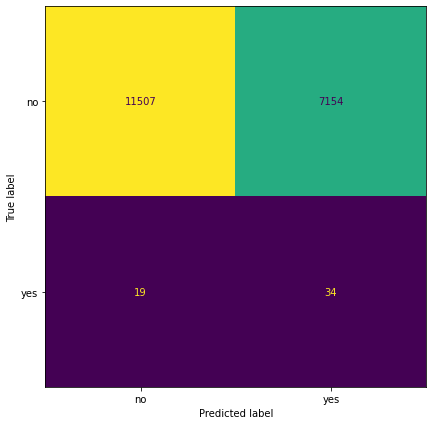

In [ ]:
# Vecchia matrice di confusione
# Matrice di confusione
ConfusionMatrixDisplay.from_estimator(pipeline, test_x, test_y, colorbar=False);

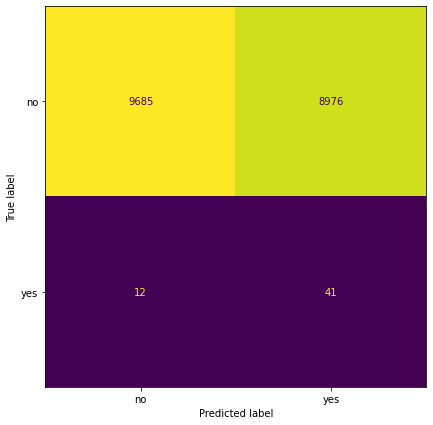

In [ ]:
# Nuova matrice di confusione
ConfusionMatrixDisplay.from_predictions(test_y, y_pred2, colorbar=False);

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


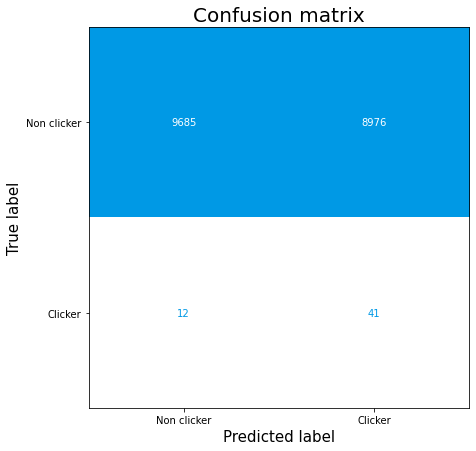

In [ ]:
# Nuova matrice di confuzione coi colori giusti
# Definisco colormap
cmap = clr.ListedColormap(["white",
                           (0.98, 0.19, 0.13, 1), # rosso
                           (0.90, 0.56, 0.16, 1), # beige
                           (0,0.6,0.9,1)]); # azzurro
ConfusionMatrixDisplay.from_predictions(test_y, y_pred2, colorbar=False, display_labels=['Non clicker','Clicker'], cmap=cmap);
plt.title('Confusion matrix', fontsize=font_title);
plt.xlabel("Predicted label", fontsize=font_label);
plt.ylabel("True label", fontsize=font_label);

# Valutazione delle performance con quantili

Massimo e minimo della distribuzione

In [ ]:
print(f"Massimo: {yes_df[yes_df['Class'] == 'yes']['Confidence of yes'].max()}\nMinimo:{yes_df[yes_df['Class'] == 'yes']['Confidence of yes'].min()}")

Massimo: 0.7263100668681307
Minimo:0.0041943645284470326


## Mediana

In [ ]:
# Individuo la mediana e divido in gruppi
group1 = yes_df[yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].median()]
group2 = yes_df[yes_df['Confidence of yes'] < yes_df['Confidence of yes'].median()]

In [ ]:
yes_df['Confidence of yes'].median()

0.46042595929396796

In [ ]:
# Guardo la probabilità del primo gruppo
print(f"Frazione di sì reali nel primo gruppo: {list(group1[group1['Class'] == 'yes'].count())[2]}/{len(group1)}={round(list(group1[group1['Class'] == 'yes'].count() / len(group1))[2], 3)}")
print(f"Frazione di sì reali nel primo gruppo su tutti i sì: {list(group1[group1['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel primo gruppo su tutti i no: {list(group1[group1['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel primo gruppo: 41/9367=0.004
Frazione di sì reali nel primo gruppo su tutti i sì: 41/53
Frazione di no reali nel primo gruppo su tutti i no: 9326/18661


In [ ]:
# Guardo la probabilità del secondo gruppo
print(f"Frazione di sì reali nel secondo gruppo: {list(group2[group2['Class'] == 'yes'].count())[2]}/{len(group2)}={round(list(group2[group2['Class'] == 'yes'].count() / len(group2))[2], 3)}")
print(f"Frazione di sì reali nel secondo gruppo su tutti i sì: {list(group2[group2['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel secondo gruppo su tutti i no: {list(group2[group2['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel secondo gruppo: 12/9347=0.001
Frazione di sì reali nel secondo gruppo su tutti i sì: 12/53
Frazione di no reali nel secondo gruppo su tutti i no: 9335/18661


## Quartili

In [ ]:
quart1 = yes_df[(yes_df['Confidence of yes'] <= yes_df['Confidence of yes'].quantile(q=1.0)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.75))]
quart2 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.75)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.5))]
quart3 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.5)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.25))]
quart4 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.25)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0))]

In [ ]:
# Quartili
print(f"q_0.75 = {yes_df['Confidence of yes'].quantile(q=0.75)}")
print(f"mediana = {yes_df['Confidence of yes'].quantile(q=0.5)}")
print(f"q_0.25 = {yes_df['Confidence of yes'].quantile(q=0.25)}")
print(f"q_0 = {yes_df['Confidence of yes'].quantile(q=0)}")

q_0.75 = 0.5505347365551725
mediana = 0.46042595929396796
q_0.25 = 0.3523377049589781
q_0 = 5.588365157436864e-06


In [ ]:
# Guardo la probabilità del primo gruppo
print(f"Frazione di sì reali nel primo gruppo: {list(quart1[quart1['Class'] == 'yes'].count())[2]}/{len(quart1)}={round(list(quart1[quart1['Class'] == 'yes'].count() / len(quart1))[2], 3)}")
print(f"Frazione di sì reali nel primo gruppo su tutti i sì: {list(quart1[quart1['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel primo gruppo su tutti i no: {list(quart1[quart1['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel primo gruppo: 24/4785=0.005
Frazione di sì reali nel primo gruppo su tutti i sì: 24/53
Frazione di no reali nel primo gruppo su tutti i no: 4761/18661


In [ ]:
# Guardo la probabilità del secondo gruppo
print(f"Frazione di sì reali nel secondo gruppo: {list(quart2[quart2['Class'] == 'yes'].count())[2]}/{len(quart2)}={round(list(quart2[quart2['Class'] == 'yes'].count() / len(quart2))[2], 3)}")
print(f"Frazione di sì reali nel secondo gruppo su tutti i sì: {list(quart2[quart2['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel secondo gruppo su tutti i no: {list(quart2[quart2['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel secondo gruppo: 17/4582=0.004
Frazione di sì reali nel secondo gruppo su tutti i sì: 17/53
Frazione di no reali nel secondo gruppo su tutti i no: 4565/18661


In [ ]:
# Guardo la probabilità del terzo gruppo
print(f"Frazione di sì reali nel terzo gruppo: {list(quart3[quart3['Class'] == 'yes'].count())[2]}/{len(quart3)}={round(list(quart3[quart3['Class'] == 'yes'].count() / len(quart3))[2], 3)}")
print(f"Frazione di sì reali nel terzo gruppo su tutti i sì: {list(quart3[quart3['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel terzo gruppo su tutti i no: {list(quart3[quart3['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel terzo gruppo: 7/4673=0.001
Frazione di sì reali nel terzo gruppo su tutti i sì: 7/53
Frazione di no reali nel terzo gruppo su tutti i no: 4666/18661


In [ ]:
# Guardo la probabilità del quarto gruppo
print(f"Frazione di sì reali nel quarto gruppo: {list(quart4[quart4['Class'] == 'yes'].count())[2]}/{len(quart4)}={round(list(quart4[quart4['Class'] == 'yes'].count() / len(quart4))[2], 3)}")
print(f"Frazione di sì reali nel quarto gruppo su tutti i sì: {list(quart4[quart4['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel quarto gruppo su tutti i no: {list(quart4[quart4['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel quarto gruppo: 5/4674=0.001
Frazione di sì reali nel quarto gruppo su tutti i sì: 5/53
Frazione di no reali nel quarto gruppo su tutti i no: 4669/18661


## Ottili

In [ ]:
ott1 = yes_df[(yes_df['Confidence of yes'] <= yes_df['Confidence of yes'].quantile(q=1.0)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.875))]
ott2 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.875)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.75))]
ott3 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.75)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.625))]
ott4 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.625)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.5))]
ott5 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.5)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.375))]
ott6 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.375)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.25))]
ott7 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.25)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.125))]
ott8 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.125)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0))]

In [ ]:
# Ottili
print(f"q_0.875 = {yes_df['Confidence of yes'].quantile(q=0.875)}")
print(f"q_0.625 = {yes_df['Confidence of yes'].quantile(q=0.625)}")
print(f"q_0.375 = {yes_df['Confidence of yes'].quantile(q=0.375)}")
print(f"q_0.125 = {yes_df['Confidence of yes'].quantile(q=0.125)}")

q_0.875 = 0.5796117531305822
q_0.625 = 0.5034094148344677
q_0.375 = 0.422171144877583
q_0.125 = 0.1976423765885055


In [ ]:
# Guardo la probabilità del primo gruppo
print(f"Frazione di sì reali nel primo gruppo: {list(ott1[ott1['Class'] == 'yes'].count())[2]}/{len(ott1)}={round(list(ott1[ott1['Class'] == 'yes'].count() / len(ott1))[2], 3)}")
print(f"Frazione di sì reali nel primo gruppo su tutti i sì: {list(ott1[ott1['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel primo gruppo su tutti i no: {list(ott1[ott1['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel primo gruppo: 16/2340=0.007
Frazione di sì reali nel primo gruppo su tutti i sì: 16/53
Frazione di no reali nel primo gruppo su tutti i no: 2324/18661


In [ ]:
# Guardo la probabilità del secondo gruppo
print(f"Frazione di sì reali nel secondo gruppo: {list(ott2[ott2['Class'] == 'yes'].count())[2]}/{len(ott2)}={round(list(ott2[ott2['Class'] == 'yes'].count() / len(ott2))[2], 3)}")
print(f"Frazione di sì reali nel secondo gruppo su tutti i sì: {list(ott2[ott2['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel secondo gruppo su tutti i no: {list(ott2[ott2['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel secondo gruppo: 8/2445=0.003
Frazione di sì reali nel secondo gruppo su tutti i sì: 8/53
Frazione di no reali nel secondo gruppo su tutti i no: 2437/18661


In [ ]:
# Guardo la probabilità del terzo ottile
print(f"Frazione di sì reali nel terzo gruppo: {list(ott3[ott3['Class'] == 'yes'].count())[2]}/{len(ott3)}={round(list(ott3[ott3['Class'] == 'yes'].count() / len(ott3))[2], 3)}")
print(f"Frazione di sì reali nel terzo gruppo su tutti i sì: {list(ott3[ott3['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel terzo gruppo su tutti i no: {list(ott3[ott3['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel terzo gruppo: 8/2238=0.004
Frazione di sì reali nel terzo gruppo su tutti i sì: 8/53
Frazione di no reali nel terzo gruppo su tutti i no: 2230/18661


In [ ]:
# Guardo la probabilità del quarto gruppo
print(f"Frazione di sì reali nel quarto gruppo: {list(ott4[ott4['Class'] == 'yes'].count())[2]}/{len(ott4)}={round(list(ott4[ott4['Class'] == 'yes'].count() / len(ott4))[2], 3)}")
print(f"Frazione di sì reali nel quarto gruppo su tutti i sì: {list(ott4[ott4['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel quarto gruppo su tutti i no: {list(ott4[ott4['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel quarto gruppo: 9/2344=0.004
Frazione di sì reali nel quarto gruppo su tutti i sì: 9/53
Frazione di no reali nel quarto gruppo su tutti i no: 2335/18661


In [ ]:
# Guardo la probabilità del quinto gruppo
print(f"Frazione di sì reali nel quinto gruppo: {list(ott5[ott5['Class'] == 'yes'].count())[2]}/{len(ott5)}={round(list(ott5[ott5['Class'] == 'yes'].count() / len(ott5))[2], 3)}")
print(f"Frazione di sì reali nel quinto gruppo su tutti i sì: {list(ott5[ott5['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel quinto gruppo su tutti i no: {list(ott5[ott5['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel quinto gruppo: 3/2329=0.001
Frazione di sì reali nel quinto gruppo su tutti i sì: 3/53
Frazione di no reali nel quinto gruppo su tutti i no: 2326/18661


In [ ]:
# Guardo la probabilità del sesto gruppo
print(f"Frazione di sì reali nel sesto gruppo: {list(ott6[ott6['Class'] == 'yes'].count())[2]}/{len(ott6)}={round(list(ott6[ott6['Class'] == 'yes'].count() / len(ott6))[2], 3)}")
print(f"Frazione di sì reali nel sesto gruppo su tutti i sì: {list(ott6[ott6['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel sesto gruppo su tutti i no: {list(ott6[ott6['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel sesto gruppo: 4/2344=0.002
Frazione di sì reali nel sesto gruppo su tutti i sì: 4/53
Frazione di no reali nel sesto gruppo su tutti i no: 2340/18661


In [ ]:
# Guardo la probabilità del settimo gruppo
print(f"Frazione di sì reali nel settimo gruppo: {list(ott7[ott7['Class'] == 'yes'].count())[2]}/{len(ott7)}={round(list(ott7[ott7['Class'] == 'yes'].count() / len(ott7))[2], 3)}")
print(f"Frazione di sì reali nel settimo gruppo su tutti i sì: {list(ott7[ott7['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel settimo gruppo su tutti i no: {list(ott7[ott7['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel settimo gruppo: 1/2336=0.0
Frazione di sì reali nel settimo gruppo su tutti i sì: 1/53
Frazione di no reali nel settimo gruppo su tutti i no: 2335/18661


In [ ]:
# Guardo la probabilità dell'ottavo gruppo
print(f"Frazione di sì reali nell'ottavo gruppo: {list(ott8[ott8['Class'] == 'yes'].count())[2]}/{len(ott8)}={round(list(ott8[ott8['Class'] == 'yes'].count() / len(ott8))[2], 3)}")
print(f"Frazione di sì reali nell'ottavo gruppo su tutti i sì: {list(ott8[ott8['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nell'ottavo gruppo su tutti i no: {list(ott8[ott8['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nell'ottavo gruppo: 4/2338=0.002
Frazione di sì reali nell'ottavo gruppo su tutti i sì: 4/53
Frazione di no reali nell'ottavo gruppo su tutti i no: 2334/18661


## Decili
Non usati

In [ ]:
dec1 = yes_df[(yes_df['Confidence of yes'] <= yes_df['Confidence of yes'].quantile(q=1.0)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.9))]
dec2 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.9)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.8))]
dec3 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.8)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.7))]
dec4 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.7)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.6))]
dec5 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.6)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.5))]
dec6 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.5)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.4))]
dec7 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.4)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.3))]
dec8 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.3)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.2))]
dec9 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.2)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.1))]
dec10 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.1)) &
               (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0))]

In [ ]:
# Decili
print(f"q_0.9 = {yes_df['Confidence of yes'].quantile(q=0.9)}")
print(f"q_0.8 = {yes_df['Confidence of yes'].quantile(q=0.8)}")
print(f"q_0.7 = {yes_df['Confidence of yes'].quantile(q=0.7)}")
print(f"q_0.6 = {yes_df['Confidence of yes'].quantile(q=0.6)}")
print(f"q_0.5 = {yes_df['Confidence of yes'].quantile(q=0.5)}")
print(f"q_0.4 = {yes_df['Confidence of yes'].quantile(q=0.4)}")
print(f"q_0.3 = {yes_df['Confidence of yes'].quantile(q=0.3)}")
print(f"q_0.2 = {yes_df['Confidence of yes'].quantile(q=0.2)}")
print(f"q_0.1 = {yes_df['Confidence of yes'].quantile(q=0.1)}")

q_0.9 = 0.5882846064420648
q_0.8 = 0.5609297757923415
q_0.7 = 0.531996660372342
q_0.6 = 0.4947585436975727
q_0.5 = 0.46042595929396796
q_0.4 = 0.4319311940603633
q_0.3 = 0.39048998502832843
q_0.2 = 0.31461897039110137
q_0.1 = 0.11477038026623741


In [ ]:
# Ottili
print(f"q_0.875 = {yes_df['Confidence of yes'].quantile(q=0.875)}")
print(f"q_0.625 = {yes_df['Confidence of yes'].quantile(q=0.625)}")
print(f"q_0.375 = {yes_df['Confidence of yes'].quantile(q=0.375)}")
print(f"q_0.125 = {yes_df['Confidence of yes'].quantile(q=0.125)}")

q_0.875 = 0.5796117531305822
q_0.625 = 0.5034094148344677
q_0.375 = 0.422171144877583
q_0.125 = 0.1976423765885055


In [ ]:
# Guardo la probabilità del primo gruppo
print(f"Frazione di sì reali nel primo gruppo: {list(dec1[dec1['Class'] == 'yes'].count())[2]}/{len(dec1)}={round(list(dec1[dec1['Class'] == 'yes'].count() / len(dec1))[2], 3)}")
print(f"Frazione di sì reali nel primo gruppo su tutti i sì: {list(dec1[dec1['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel primo gruppo su tutti i no: {list(dec1[dec1['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel primo gruppo: 9/1872=0.005
Frazione di sì reali nel primo gruppo su tutti i sì: 9/53
Frazione di no reali nel primo gruppo su tutti i no: 1863/18661


In [ ]:
# Guardo la probabilità del secondo gruppo
print(f"Frazione di sì reali nel secondo gruppo: {list(dec2[dec2['Class'] == 'yes'].count())[2]}/{len(dec2)}={round(list(dec2[dec2['Class'] == 'yes'].count() / len(dec2))[2], 3)}")
print(f"Frazione di sì reali nel secondo gruppo su tutti i sì: {list(dec2[dec2['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel secondo gruppo su tutti i no: {list(dec2[dec2['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel secondo gruppo: 15/2194=0.007
Frazione di sì reali nel secondo gruppo su tutti i sì: 15/53
Frazione di no reali nel secondo gruppo su tutti i no: 2179/18661


In [ ]:
# Guardo la probabilità del terzo decile
print(f"Frazione di sì reali nel terzo gruppo: {list(dec3[dec3['Class'] == 'yes'].count())[2]}/{len(dec3)}={round(list(dec3[dec3['Class'] == 'yes'].count() / len(dec3))[2], 3)}")
print(f"Frazione di sì reali nel terzo gruppo su tutti i sì: {list(dec3[dec3['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel terzo gruppo su tutti i no: {list(dec3[dec3['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel terzo gruppo: 4/1548=0.003
Frazione di sì reali nel terzo gruppo su tutti i sì: 4/53
Frazione di no reali nel terzo gruppo su tutti i no: 1544/18661


In [ ]:
# Guardo la probabilità del quarto gruppo
print(f"Frazione di sì reali nel quarto gruppo: {list(dec4[dec4['Class'] == 'yes'].count())[2]}/{len(dec4)}={round(list(dec4[dec4['Class'] == 'yes'].count() / len(dec4))[2], 3)}")
print(f"Frazione di sì reali nel quarto gruppo su tutti i sì: {list(dec4[dec4['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel quarto gruppo su tutti i no: {list(dec4[dec4['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel quarto gruppo: 7/1894=0.004
Frazione di sì reali nel quarto gruppo su tutti i sì: 7/53
Frazione di no reali nel quarto gruppo su tutti i no: 1887/18661


In [ ]:
# Guardo la probabilità del quinto gruppo
print(f"Frazione di sì reali nel quinto gruppo: {list(dec5[dec5['Class'] == 'yes'].count())[2]}/{len(dec5)}={round(list(dec5[dec5['Class'] == 'yes'].count() / len(dec5))[2], 3)}")
print(f"Frazione di sì reali nel quinto gruppo su tutti i sì: {list(dec5[dec5['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel quinto gruppo su tutti i no: {list(dec5[dec5['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel quinto gruppo: 6/1859=0.003
Frazione di sì reali nel quinto gruppo su tutti i sì: 6/53
Frazione di no reali nel quinto gruppo su tutti i no: 1853/18661


In [ ]:
# Guardo la probabilità del sesto gruppo
print(f"Frazione di sì reali nel sesto gruppo: {list(dec6[dec6['Class'] == 'yes'].count())[2]}/{len(dec6)}={round(list(dec6[dec6['Class'] == 'yes'].count() / len(dec6))[2], 3)}")
print(f"Frazione di sì reali nel sesto gruppo su tutti i sì: {list(dec6[dec6['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel sesto gruppo su tutti i no: {list(dec6[dec6['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel sesto gruppo: 2/1861=0.001
Frazione di sì reali nel sesto gruppo su tutti i sì: 2/53
Frazione di no reali nel sesto gruppo su tutti i no: 1859/18661


In [ ]:
# Guardo la probabilità del settimo gruppo
print(f"Frazione di sì reali nel settimo gruppo: {list(dec7[dec7['Class'] == 'yes'].count())[2]}/{len(dec7)}={round(list(dec7[dec7['Class'] == 'yes'].count() / len(dec7))[2], 3)}")
print(f"Frazione di sì reali nel settimo gruppo su tutti i sì: {list(dec7[dec7['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel settimo gruppo su tutti i no: {list(dec7[dec7['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel settimo gruppo: 3/1900=0.002
Frazione di sì reali nel settimo gruppo su tutti i sì: 3/53
Frazione di no reali nel settimo gruppo su tutti i no: 1897/18661


In [ ]:
# Guardo la probabilità dell'ottavo gruppo
print(f"Frazione di sì reali nell'ottavo gruppo: {list(dec8[dec8['Class'] == 'yes'].count())[2]}/{len(dec8)}={round(list(dec8[dec8['Class'] == 'yes'].count() / len(dec8))[2], 3)}")
print(f"Frazione di sì reali nell'ottavo gruppo su tutti i sì: {list(dec8[dec8['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nell'ottavo gruppo su tutti i no: {list(dec8[dec8['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nell'ottavo gruppo: 2/1845=0.001
Frazione di sì reali nell'ottavo gruppo su tutti i sì: 2/53
Frazione di no reali nell'ottavo gruppo su tutti i no: 1843/18661


In [ ]:
# Guardo la probabilità del nono gruppo
print(f"Frazione di sì reali nel nono gruppo: {list(dec7[dec7['Class'] == 'yes'].count())[2]}/{len(dec7)}={round(list(dec7[dec7['Class'] == 'yes'].count() / len(dec7))[2], 3)}")
print(f"Frazione di sì reali nel nono gruppo su tutti i sì: {list(dec7[dec7['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel nono gruppo su tutti i no: {list(dec7[dec7['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel nono gruppo: 3/1900=0.002
Frazione di sì reali nel nono gruppo su tutti i sì: 3/53
Frazione di no reali nel nono gruppo su tutti i no: 1897/18661


In [ ]:
# Guardo la probabilità del decimo gruppo
print(f"Frazione di sì reali nel decimo gruppo: {list(dec8[dec8['Class'] == 'yes'].count())[2]}/{len(dec8)}={round(list(dec8[dec8['Class'] == 'yes'].count() / len(dec8))[2], 3)}")
print(f"Frazione di sì reali nel decimo gruppo su tutti i sì: {list(dec8[dec8['Class'] == 'yes'].count())[2]}/{Nyes}")
print(f"Frazione di no reali nel decimo gruppo su tutti i no: {list(dec8[dec8['Class'] == 'no'].count())[2]}/{Nno}")

Frazione di sì reali nel decimo gruppo: 2/1845=0.001
Frazione di sì reali nel decimo gruppo su tutti i sì: 2/53
Frazione di no reali nel decimo gruppo su tutti i no: 1843/18661


## Grafici

Mediana

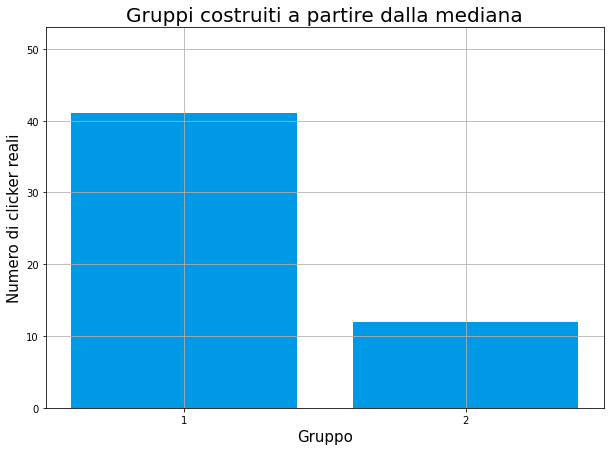

In [ ]:
# Dataset mediana
group1 = yes_df[yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].median()]
group2 = yes_df[yes_df['Confidence of yes'] < yes_df['Confidence of yes'].median()]

# Numero di sì nei due gruppi
g1 = list(group1[group1['Class'] == 'yes'].count())[2]
g2 = list(group2[group2['Class'] == 'yes'].count())[2]

# Plot
asse_y = [g1, g2] # Numero di sì nei due gruppi
asse_x = ['1', '2'] # Nomi dei gruppi

plt.bar(asse_x, asse_y, color=colore_scelto);
plt.xlabel('Gruppo', fontsize=font_label);
plt.ylabel('Numero di clicker reali', fontsize=font_label);
plt.title('Gruppi costruiti a partire dalla mediana', fontsize=font_title);
plt.ylim(0, 53);
plt.grid();

Quartili

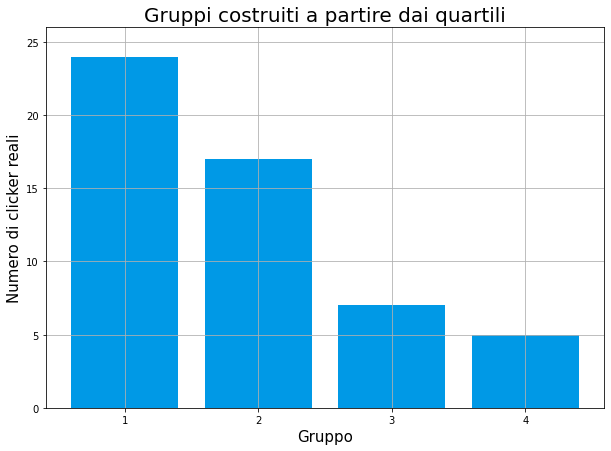

In [ ]:
# Dataset quartili
quart1 = yes_df[(yes_df['Confidence of yes'] <= yes_df['Confidence of yes'].quantile(q=1.0)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.75))]
quart2 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.75)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.5))]
quart3 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.5)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.25))]
quart4 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.25)) &
                (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0))]

# Numero di sì nei quattro gruppi
g1 = list(quart1[quart1['Class'] == 'yes'].count())[2]
g2 = list(quart2[quart2['Class'] == 'yes'].count())[2]
g3 = list(quart3[quart3['Class'] == 'yes'].count())[2]
g4 = list(quart4[quart4['Class'] == 'yes'].count())[2]

# Plot
asse_y = [g1, g2, g3, g4] # Numero di sì nei quattro gruppi
asse_x = ['1', '2', '3', '4'] # Nomi dei gruppi

plt.bar(asse_x, asse_y, color=colore_scelto);
plt.xlabel('Gruppo', fontsize=font_label);
plt.ylabel('Numero di clicker reali', fontsize=font_label);
plt.title('Gruppi costruiti a partire dai quartili', fontsize=font_title);
plt.ylim(0, 26);
plt.grid();

Ottili

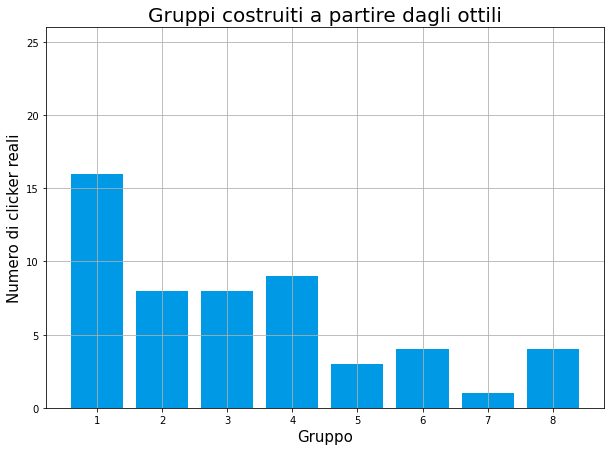

In [ ]:
# Dataset ottili
ott1 = yes_df[(yes_df['Confidence of yes'] <= yes_df['Confidence of yes'].quantile(q=1.0)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.875))]
ott2 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.875)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.75))]
ott3 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.75)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.625))]
ott4 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.625)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.5))]
ott5 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.5)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.375))]
ott6 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.375)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.25))]
ott7 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.25)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0.125))]
ott8 = yes_df[(yes_df['Confidence of yes'] < yes_df['Confidence of yes'].quantile(q=0.125)) &
              (yes_df['Confidence of yes'] >= yes_df['Confidence of yes'].quantile(q=0))]

# Numero di sì negli otto gruppi
g1 = list(ott1[ott1['Class'] == 'yes'].count())[2]
g2 = list(ott2[ott2['Class'] == 'yes'].count())[2]
g3 = list(ott3[ott3['Class'] == 'yes'].count())[2]
g4 = list(ott4[ott4['Class'] == 'yes'].count())[2]
g5 = list(ott5[ott5['Class'] == 'yes'].count())[2]
g6 = list(ott6[ott6['Class'] == 'yes'].count())[2]
g7 = list(ott7[ott7['Class'] == 'yes'].count())[2]
g8 = list(ott8[ott8['Class'] == 'yes'].count())[2]

# Plot
asse_y = [g1, g2, g3, g4, g5, g6, g7, g8] # Numero di sì negli otto gruppi
asse_x = ['1','2','3','4','5','6','7','8'] # Nomi dei gruppi

plt.bar(asse_x, asse_y, color=colore_scelto);
plt.xlabel('Gruppo', fontsize=font_label);
plt.ylabel('Numero di clicker reali', fontsize=font_label);
plt.title('Gruppi costruiti a partire dagli ottili', fontsize=font_title);
plt.ylim(0, 26);
plt.grid();